# Developing an AI application

This project trains an image classifier to recognize different species of flowers. 
The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [29]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch
import json
from torchvision import datasets, transforms, models
import helper
from PIL import Image


## Load the data

Use `torchvision` to load the data First apply transformations such as random scaling, cropping, and flipping. Also resize data to 224x224 pixels as required by the pre-trained networks.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [20]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [21]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                ])
testvalid_transforms = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


# Load the datasets with ImageFolder
trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
testset = datasets.ImageFolder(test_dir, transform=testvalid_transforms)
validset = datasets.ImageFolder(valid_dir, transform=testvalid_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True,batch_size=32)
testloader = torch.utils.data.DataLoader(testset, shuffle=False,batch_size=32)
validloader = torch.utils.data.DataLoader(validset, shuffle=False,batch_size=32)

### Label mapping

Load mappings from category label to category name with cat_to_name json module

In [22]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

* Load a pre-trained network 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [23]:
# Build and train your network
model = models.vgg16(pretrained=True)


for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(25088, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(1024, 102),
                                 nn.LogSoftmax(dim=1))
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.NLLLoss()

 #Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.00005)


In [24]:
# Build and train the network
epochs = 2
steps = 0
running_loss = 0
print_every = 5

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device);

In [18]:

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:

                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/2.. Train loss: 9.057.. Validation loss: 4.398.. Validation accuracy: 0.058
Epoch 1/2.. Train loss: 4.352.. Validation loss: 4.287.. Validation accuracy: 0.079
Epoch 1/2.. Train loss: 4.132.. Validation loss: 4.191.. Validation accuracy: 0.101
Epoch 1/2.. Train loss: 4.097.. Validation loss: 4.093.. Validation accuracy: 0.108
Epoch 1/2.. Train loss: 4.103.. Validation loss: 3.965.. Validation accuracy: 0.136
Epoch 1/2.. Train loss: 3.846.. Validation loss: 3.848.. Validation accuracy: 0.168
Epoch 1/2.. Train loss: 3.713.. Validation loss: 3.742.. Validation accuracy: 0.203
Epoch 1/2.. Train loss: 3.487.. Validation loss: 3.646.. Validation accuracy: 0.209
Epoch 1/2.. Train loss: 3.641.. Validation loss: 3.559.. Validation accuracy: 0.224
Epoch 1/2.. Train loss: 3.306.. Validation loss: 3.440.. Validation accuracy: 0.258
Epoch 1/2.. Train loss: 3.502.. Validation loss: 3.295.. Validation accuracy: 0.298
Epoch 1/2.. Train loss: 3.259.. Validation loss: 3.191.. Validation accuracy

## Testing the network

Run the test images through the network and measure the accuracy.

In [15]:
# Do validation on the test set
accuracy=0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:

        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
                    
                # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(f"Test accuracy: {accuracy/len(testloader):.3f}")

Test accuracy: 0.723


## Save the checkpoint



In [12]:
model.class_to_idx = trainset.class_to_idx

In [16]:
# Save the checkpoint 
checkpoint = {
    'arch': 'vgg16',
    'state_dict': model.state_dict(),
    'hidden_units': 1024,
    'epochs' : epochs,
    'output_size': 102,
    'learning_rate': 0.00005
}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint


In [26]:
# Write a function that loads a checkpoint and rebuilds the model

checkpoint = torch.load('checkpoint.pth',map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])

# Inference for classification

NWrite a function to use a trained network for inference. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First, repeat the image pre-processing steps.

## Image Preprocessing

Use `PIL` to load the image. Resize the images where the shortest side is 256 pixels, keeping the aspect ratio. Crop out the center 224x224 portion of the image.  Convert image values from 0 to 1 float.  Normalize the distribution of image values to have a standard mean and standard deviation.  Re-order the dimension ordering within a Numpy array.

In [64]:
#Image Preprocessing
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    pil_image=Image.open(image)
    pil_image=pil_image.resize((256, 256))
    width,height=pil_image.size
    left=(width-224)/2
    top=(height-224)/2
    right=left+224
    bottom=top+224
    pil_image=pil_image.crop((left, top, right, bottom))
    np_image=np.array(pil_image)/255
    np_image=(np_image-[0.485, 0.456, 0.406])/[0.229, 0.224, 0.225]
    np_image=np_image.transpose((2,0,1))
    image=torch.from_numpy(np_image)
    return image

Checking that the the passing the image through the processing function and another function to do the un-processing returns the original data.

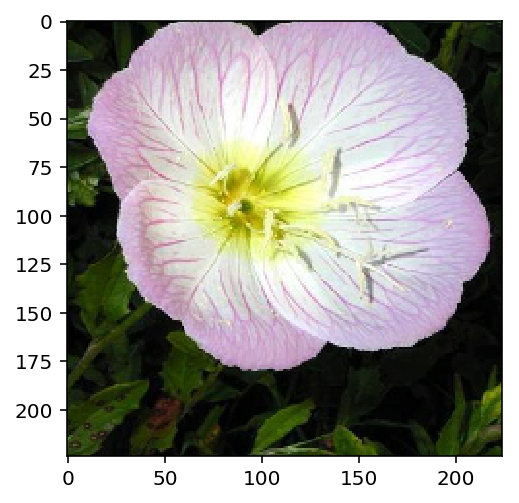

In [65]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
imshow(process_image(test_dir+'/1/image_06743.jpg'))

## Class Prediction

Write a function for making predictions with the model (top 5 most likely labels as well as corresponding probabilities). 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [70]:
def predict(image_path, checkpoint, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    pt = torch.load(checkpoint,map_location=lambda storage, loc: storage)
    model.load_state_dict(pt['state_dict'])
    model.eval()
    image=process_image(image_path)
    image = image.unsqueeze_(0)
    image = image.float()
    image=image.to(device)
    with torch.no_grad():
    # TODO: Implement the code to predict the class from an image file
        output = model.forward(image)   
        ps=torch.exp(output)
        top_probs, top_class = ps.topk(topk, dim=1)
    return top_probs, top_class
    
top_probs, top_class = predict(test_dir+'/1/image_06743.jpg', 'checkpoint.pth', topk=5)
print(top_probs)
print(top_class)

tensor([[ 0.2900,  0.2307,  0.1510,  0.1287,  0.0602]])
tensor([[   0,   84,   49,  100,   87]])


## Checking the model

Testing the model with one specific flower.

Pink Primrose 



<Container object of 5 artists>

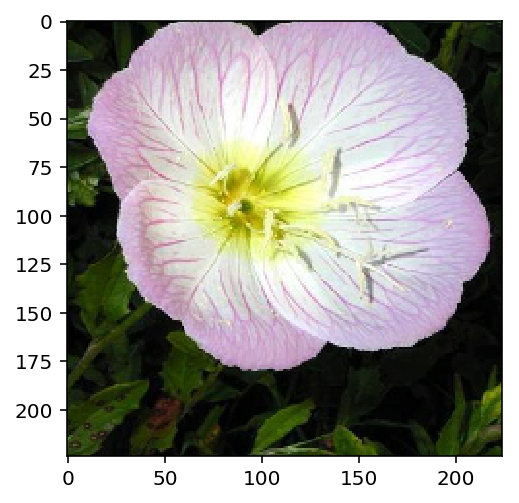

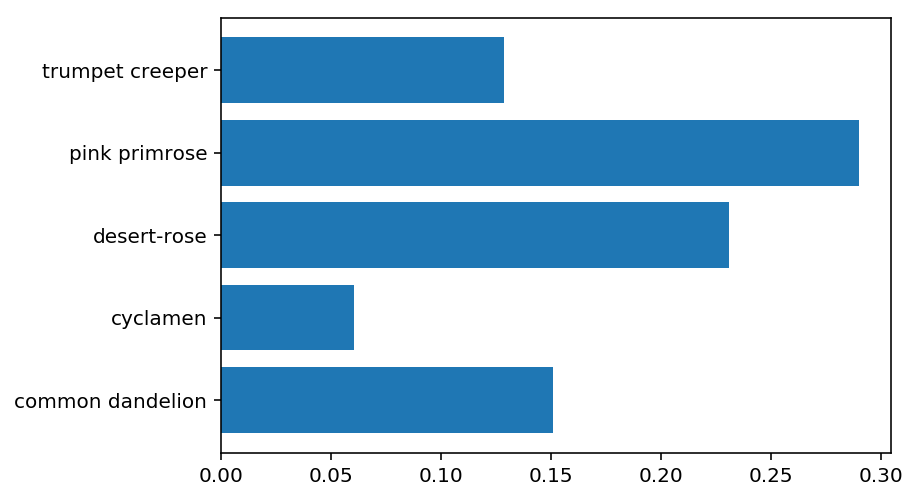

In [112]:
# TODO: Display an image along with the top 5 classes
sanity_img = test_dir+'/1/image_06743.jpg'
prob, class_id = predict(sanity_img, 'checkpoint.pth', topk=5)
class_id=np.array(class_id)[0]
print("Pink Primrose \n")
imshow(process_image(sanity_img))
flower_names=[]
for num in class_id:
    flower_names.append(cat_to_name[str(num+1)])
            
plt.figure()
plt.barh(flower_names, np.array(prob)[0])

